In [1]:
from garminconnect import Garmin
from dotenv import load_dotenv
import os

load_dotenv()

email = os.getenv("GARMIN_EMAIL")
password = os.getenv("GARMIN_PASSWORD")

if not email or not password:
    raise ValueError("Missing credentials - check .env")

client = Garmin(email, password)
client.login()

activities = client.get_activities(0, 200)
#print(activities)
print(type(activities))

<class 'list'>


In [2]:
# get activity details using activityId
activity_details = [client.get_activity_details(activity["activityId"]) 
                         for activity in activities if "activityId" in activity]

#print(activity_details)

In [3]:
import pandas as pd

activities = pd.DataFrame(activities)
activity_details = pd.DataFrame(activity_details)

In [4]:
merged_activities = pd.merge(activities, activity_details, on="activityId", how="inner")

In [5]:
#print(merged_activities.columns.tolist())

In [6]:
columns = [
    "activityId", "activityName", "startTimeLocal", "distance", "duration",
    "averageSpeed", "maxSpeed", "startLatitude", "startLongitude", "calories",
    "averageHR", "maxHR", "aerobicTrainingEffect", "anaerobicTrainingEffect",
    "vO2MaxValue", "activityType", "geoPolylineDTO"
]

df = merged_activities.reindex(columns=columns)
df

,activityId,activityName,startTimeLocal,distance,duration,averageSpeed,maxSpeed,startLatitude,startLongitude,calories,averageHR,maxHR,aerobicTrainingEffect,anaerobicTrainingEffect,vO2MaxValue,activityType,geoPolylineDTO
0,20384217511,København Løb,2025-09-14 15:54:50,5465.859863,1842.461060,2.967000,3.415,55.648703,12.614179,401.0,159.0,179.0,3.4,0.0,55.0,"{'typeId': 1, 'typeKey': 'running', 'parentTyp...","{'startPoint': {'lat': 55.648703472688794, 'lo..."
1,20270687313,København Løb,2025-09-03 19:41:39,3636.060059,1441.301025,2.523000,3.751,55.658232,12.642686,252.0,139.0,169.0,2.7,0.0,55.0,"{'typeId': 1, 'typeKey': 'running', 'parentTyp...","{'startPoint': {'lat': 55.658231768757105, 'lo..."
2,20270277735,København Løb,2025-09-03 19:22:53,2516.000000,669.671021,3.757000,4.227,55.648724,12.614247,185.0,NaN,NaN,1.0,0.0,NaN,"{'typeId': 1, 'typeKey': 'running', 'parentTyp...","{'startPoint': {'lat': 55.64872417598963, 'lon..."
3,20270276384,København Løb,2025-08-29 17:39:23,4015.500000,1614.714966,2.487000,4.684,55.648652,12.613798,270.0,135.0,168.0,3.0,0.0,56.0,"{'typeId': 1, 'typeKey': 'running', 'parentTyp...","{'startPoint': {'lat': 55.648652175441384, 'lo..."
4,20206302377,København Løb,2025-08-28 16:47:40,3788.790039,1281.812012,2.956000,4.143,55.667672,12.578329,271.0,156.0,174.0,3.1,0.2,55.0,"{'typeId': 1, 'typeKey': 'running', 'parentTyp...","{'startPoint': {'lat': 55.66767197102308, 'lon..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,12126641757,Indendørs roning,2023-09-28 18:42:27,1125.000000,301.627014,3.729772,NaN,NaN,NaN,71.0,157.0,173.0,2.0,0.0,NaN,"{'typeId': 32, 'typeKey': 'indoor_rowing', 'pa...",None
87,12126563299,Løbebånd,2023-09-28 18:28:53,1440.000000,557.601990,2.582487,0.000,NaN,NaN,128.0,150.0,160.0,2.4,0.0,NaN,"{'typeId': 18, 'typeKey': 'treadmill_running',...",None
88,12126463007,Stepper,2023-09-28 18:06:36,0.000000,1213.629028,0.000000,NaN,NaN,NaN,282.0,156.0,170.0,3.2,0.0,NaN,"{'typeId': 31, 'typeKey': 'stair_climbing', 'p...",None
89,12120519208,Slap af og fokusér,2023-09-27 19:42:05,NaN,938.000000,NaN,NaN,NaN,NaN,0.0,87.0,105.0,0.1,0.0,NaN,"{'typeId': 164, 'typeKey': 'breathwork', 'pare...",None


In [7]:
import ast
import json
import folium
from folium.plugins import HeatMap

all_points = []

for i, row in df.iterrows():
    try:
        # Convert to Python dict
        data_str = row['geoPolylineDTO']
        
        # Handle JSON-style strings with null/true/false
        if isinstance(data_str, str):
            data_str = data_str.replace("null", "None").replace("true", "True").replace("false", "False")
            polyline_data = ast.literal_eval(data_str)
        else:
            polyline_data = data_str
        
        # Extract polyline
        polyline = polyline_data.get('polyline', [])
        
        for point in polyline:
            lat = point.get('lat')
            lon = point.get('lon')
            if lat is not None and lon is not None:
                all_points.append([lat, lon])
    except Exception as e:
        print(f"Skipping row {i} due to error: {e}")

print(f"Collected {len(all_points)} points")

# Create map centered on Copenhagen 
m = folium.Map(location=[55.6761, 12.5683], zoom_start=12)

# Add heatmap only if points exist
if all_points:
    HeatMap(all_points, radius=8, blur=15, max_zoom=15).add_to(m)
else:
    print("No points found — check parsing logic")

# Save map
output_file = "activity_heatmap.html"
m.save(output_file)
print(f"Heatmap saved to {output_file}")

Skipping row 44 due to error: 'NoneType' object has no attribute 'get'
Skipping row 49 due to error: 'NoneType' object has no attribute 'get'
Skipping row 50 due to error: 'NoneType' object has no attribute 'get'
Skipping row 52 due to error: 'NoneType' object has no attribute 'get'
Skipping row 53 due to error: 'NoneType' object has no attribute 'get'
Skipping row 54 due to error: 'NoneType' object has no attribute 'get'
Skipping row 55 due to error: 'NoneType' object has no attribute 'get'
Skipping row 56 due to error: 'NoneType' object has no attribute 'get'
Skipping row 57 due to error: 'NoneType' object has no attribute 'get'
Skipping row 58 due to error: 'NoneType' object has no attribute 'get'
Skipping row 60 due to error: 'NoneType' object has no attribute 'get'
Skipping row 61 due to error: 'NoneType' object has no attribute 'get'
Skipping row 62 due to error: 'NoneType' object has no attribute 'get'
Skipping row 64 due to error: 'NoneType' object has no attribute 'get'
Skippi

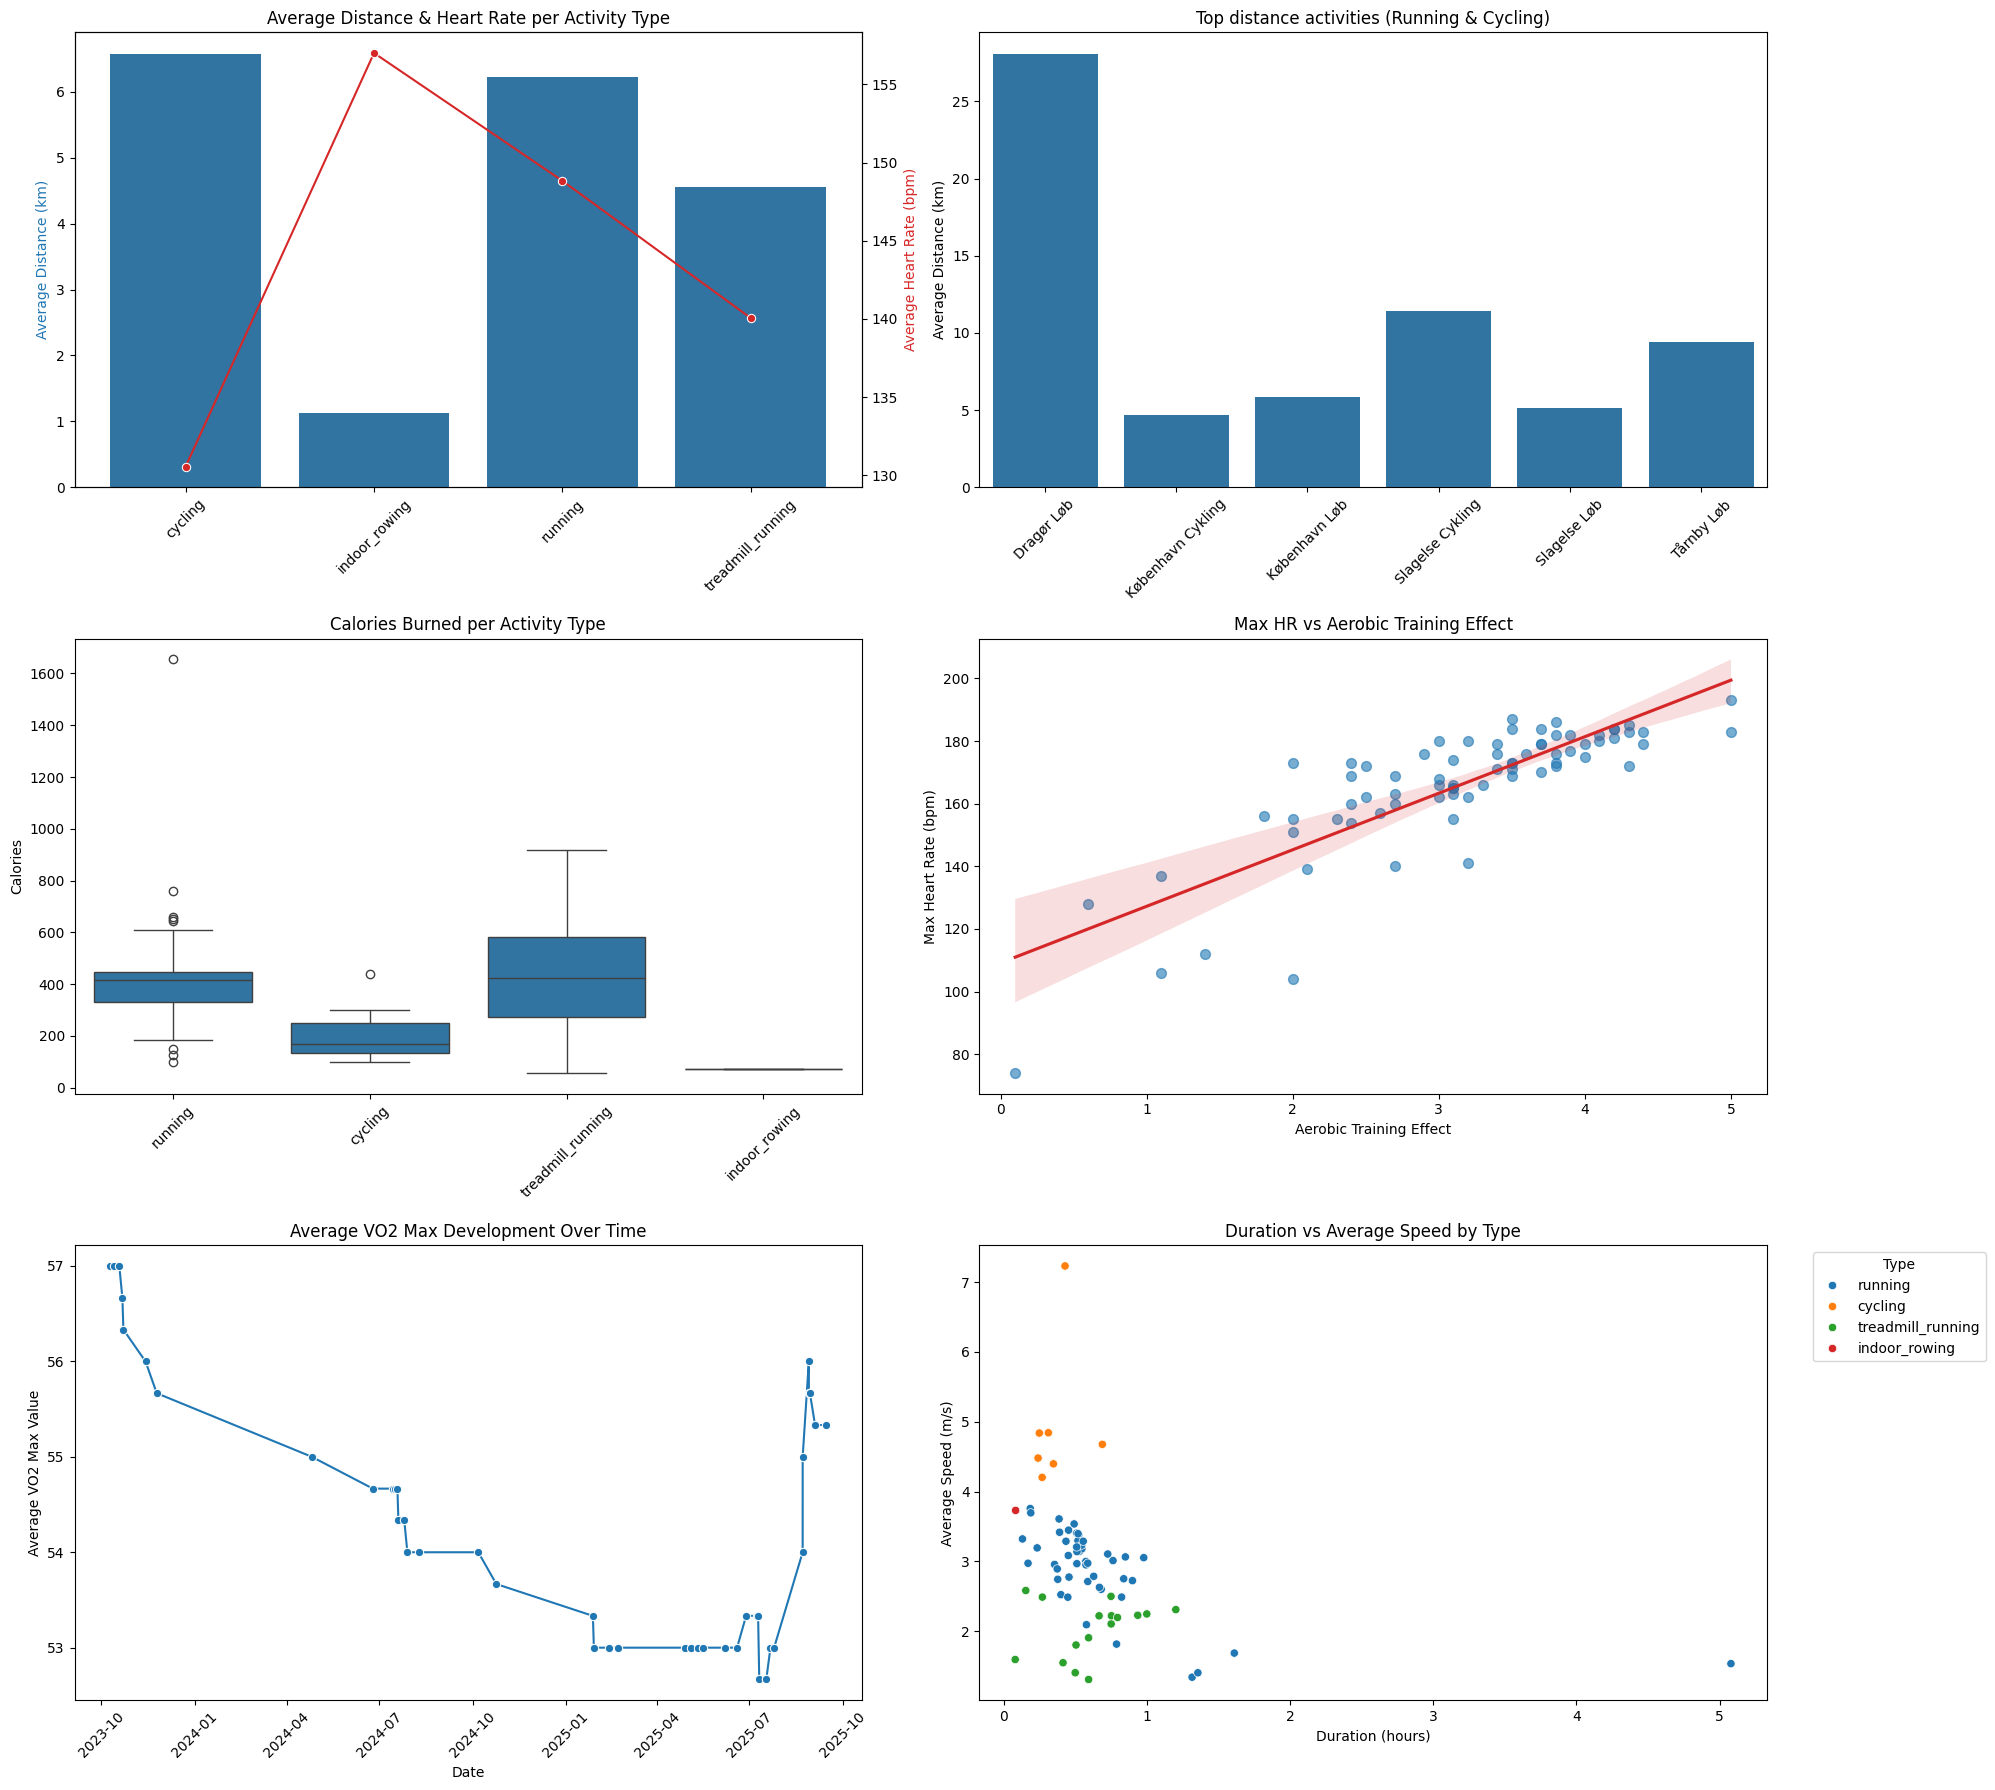

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ------------------------
# Data Preparation
# ------------------------

# Filter out zero distance
df_nonzero = df[df['distance'] > 0].copy()

# Extract typeKey safely
df_nonzero['typeKey'] = df_nonzero['activityType'].apply(lambda x: x['typeKey'] if isinstance(x, dict) else 'unknown')

# Aggregate distance and heart rate by activity type
agg_type = df_nonzero.groupby('typeKey').agg({
    'distance':'mean',
    'averageHR':'mean',
    'maxHR':'mean',
    'calories':'mean'
}).reset_index()

# Average distance per activityName (only running or cycling)
df_run_cycle = df_nonzero[df_nonzero['typeKey'].isin(['running', 'cycling'])]
agg_run_cycle = df_run_cycle.groupby('activityName')['distance'].mean().reset_index()

# VO2 Max development over time (rolling average)
df_vo2 = df_nonzero[df_nonzero['vO2MaxValue'].notnull()].copy()
df_vo2['startTimeLocal'] = pd.to_datetime(df_vo2['startTimeLocal'])
df_vo2.sort_values('startTimeLocal', inplace=True)
df_vo2['vO2Max_avg'] = df_vo2['vO2MaxValue'].rolling(window=3, min_periods=1).mean()

# ------------------------
# Plotting
# ------------------------

# Colors
color_blue = '#1f77b4'
color_red = '#d62728'

# Set up figure
fig, axes = plt.subplots(3, 2, figsize=(20,18))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# --- 1. Distance per Activity Type with Average HR line ---
agg_type['distance_km'] = agg_type['distance'] / 1000 
ax1 = axes[0,0]
sns.barplot(data=agg_type, x='typeKey', y='distance_km', errorbar=None, ax=ax1, color=color_blue)
ax1.set_ylabel('Average Distance (km)', color=color_blue)
ax1.set_xlabel('')
ax1.tick_params(axis='x', rotation=45)

ax1_twin = ax1.twinx()
sns.lineplot(data=agg_type, x='typeKey', y='averageHR', marker='o', color=color_red, ax=ax1_twin)
ax1_twin.set_ylabel('Average Heart Rate (bpm)', color=color_red)
ax1.set_title("Average Distance & Heart Rate per Activity Type")

# --- 2. Average Distance per Activity Name (Running & Cycling) ---
agg_run_cycle['distance_km'] = agg_run_cycle['distance'] / 1000  
sns.barplot(data=agg_run_cycle, x='activityName', y='distance_km', ax=axes[0,1], color=color_blue, errorbar=None)
axes[0,1].set_title("Top distance activities (Running & Cycling)")
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel("Average Distance (km)")
axes[0,1].tick_params(axis='x', rotation=45)

# --- 3. Calories per Activity Type ---
sns.boxplot(data=df_nonzero, x='typeKey', y='calories', ax=axes[1,0], color=color_blue)
axes[1,0].set_title("Calories Burned per Activity Type")
axes[1,0].set_xlabel('')
axes[1,0].set_ylabel("Calories")
axes[1,0].tick_params(axis='x', rotation=45)

# --- 4. Max HR vs Aerobic Training Effect ---
sns.regplot(data=df_nonzero, x='aerobicTrainingEffect', y='maxHR', ax=axes[1,1],
            scatter_kws={'s':50, 'alpha':0.6}, line_kws={'color':color_red})
axes[1,1].set_title("Max HR vs Aerobic Training Effect")
axes[1,1].set_xlabel("Aerobic Training Effect")
axes[1,1].set_ylabel("Max Heart Rate (bpm)")

# --- 5. Average VO2 Max development over time (rolling average) ---
sns.lineplot(data=df_vo2, x='startTimeLocal', y='vO2Max_avg', marker='o', color=color_blue, ax=axes[2,0])
axes[2,0].set_title("Average VO2 Max Development Over Time")
axes[2,0].set_xlabel("Date")
axes[2,0].set_ylabel("Average VO2 Max Value")
axes[2,0].tick_params(axis='x', rotation=45)

# --- 6. Duration vs Average Speed (hours) ---
sns.scatterplot(
    data=df_nonzero, 
    x=df_nonzero['duration'] / 3600,  # convert seconds to hours
    y='averageSpeed', 
    hue='typeKey', 
    ax=axes[2,1]
)
axes[2,1].set_title("Duration vs Average Speed by Type")
axes[2,1].set_xlabel("Duration (hours)")
axes[2,1].set_ylabel("Average Speed (m/s)")
axes[2,1].legend(title='Type', bbox_to_anchor=(1.05, 1), loc=2)

plt.tight_layout()
plt.show()


#### Regression Line

| Training Effect (x) | Max Heart Rate (y) |
|--------------------|------------------|
| 1                  | 150              |
| 2                  | 155              |
| 3                  | 160              |
| 4                  | 165              |
| 5                  | 170              |

<br><br>

$$
\text{slope} = \frac{y_2 - y_1}{x_2 - x_1} 
= \frac{170 - 150}{5 - 1} 
= \frac{20}{4} 
= 5
$$

$$
\text{intercept} = y_1 - (\text{slope} \cdot x_1) 
= 150 - (5 \cdot 1) 
= 145
$$